In [1]:
import json
import h5py
import numpy as np
from torch import nn
import torch
from torch import stft
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import PIL
from tqdm import tqdm
import os

from utils.data_utils import load_recording
from utils.data_utils import plot_spec, plot_first_n
from utils.segments_utils import get_valid_sections

In [2]:

sample_files = [
'/home/ubuntu/small_data/small_data/link-016df838-c633-44c3-b8b9-b7ab7d27f895--994809a0-66da-4f86-894e-eea4adbb77a5_1703511748082_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-02662e8a-027d-4fa4-b4d0-995e00939507--d4574202-0b42-4002-8300-5a3a28f03853_1703759634899_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-02d9b416-6442-4a54-82da-10b2d9ee3e95--389ac5ef-48e9-4aa9-ba9f-667d3a3f93f0_1705770926423_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-0311138e-192b-45e0-97be-d016aeeeb6f6--5795b6e4-a39a-402d-8a7e-5bf5803f7c6c_1707478687789_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-0377963b-eac7-4a04-a5fc-2705dc46c88e--273b725c-f4b5-4b54-89e2-18768e193079_1703195056872_session_eeg.h5',
"/home/ubuntu/small_data/small_data/link-03ebd7cf-69b5-45c2-9516-6fa454fa9a8b--c5024dcc-835f-4c66-b9f1-b7b863781f28_1705868749090_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-046c5899-ed8e-472b-9c4f-62d01c59f7b5--a1979d86-55bc-40f6-b0db-24331cf5fd85_1706280887198_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-0476e1f2-0dea-4ce3-988e-824c0ab7903c--3aef32ec-e5dc-430d-9711-a19f1570f656_1707315417457_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-048ff38b-c902-48e0-918c-b04d5905d932--c2865aa5-d35d-4303-901b-8068b043dc6e_1703655818120_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-0510a54c-bc6e-4d5d-9975-83cec1446e31--2c16de89-aef2-464b-94a5-3a85a85f5b5a_1706079381006_session_eeg.h5",
]

In [3]:
data, _, _ = load_recording(sample_files[0])
data.shape

(4, 1724256)

In [4]:
def band_pass(data, min_freq, max_freq):
    assert min_freq < max_freq, 'you are retard'
    bin_freqs = torch.abs(torch.fft.fftfreq(data.shape[1], d=1 / 250))
    mask_for_zero = (bin_freqs >= max_freq) | (bin_freqs <= min_freq)

    freqs = torch.fft.fft(data, axis=1)
    freqs[:, mask_for_zero] = 0
    
    filtered = torch.fft.ifft(freqs, axis=1)
    filtered = filtered.real
    discard_samples = 250 * 20 * 20 # experiment shows that ripples from step between stard and end subside after 20 sec, lets add 10x safety
    filtered = filtered[:, discard_samples:-discard_samples]
    
    return filtered


filtered_data = band_pass(torch.tensor(data, device='cuda'), 1, 40).cpu()


In [5]:
filtered_data[:100]

tensor([[ 2.4484e-05,  2.7404e-05,  2.6779e-05,  ..., -4.2779e-07,
         -6.2055e-06, -9.5929e-06],
        [ 1.8498e-05,  2.3415e-05,  2.2510e-05,  ...,  4.3684e-06,
          1.5819e-05,  2.4776e-05],
        [ 2.9512e-05,  2.4748e-05,  2.1080e-05,  ..., -1.4671e-05,
          3.5207e-05,  6.6187e-05],
        [ 2.6485e-05,  2.5703e-05,  2.5526e-05,  ...,  3.4239e-06,
         -6.4904e-06, -7.1545e-06]])

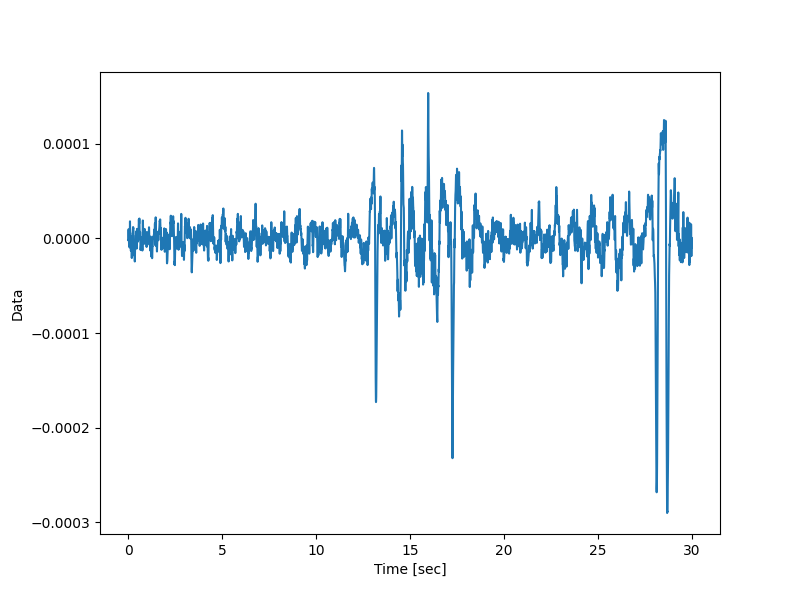

In [6]:
plot_first_n(filtered_data[0, -250 * 30:], n=None)

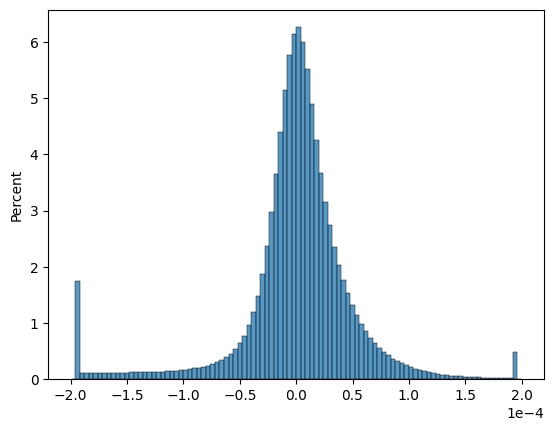

In [7]:
import seaborn as sns 

clipped = torch.clip(filtered_data, -1.95e-4, 1.95e-4)
sns.histplot(clipped.flatten().cpu().numpy(), bins=100, binrange=(-0.0002, 0.0002), stat='percent')
plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

In [8]:
is_clipping = torch.any(torch.abs(clipped) == 1.95e-4, axis=0)
is_clipping.float().mean()

tensor(0.0383)

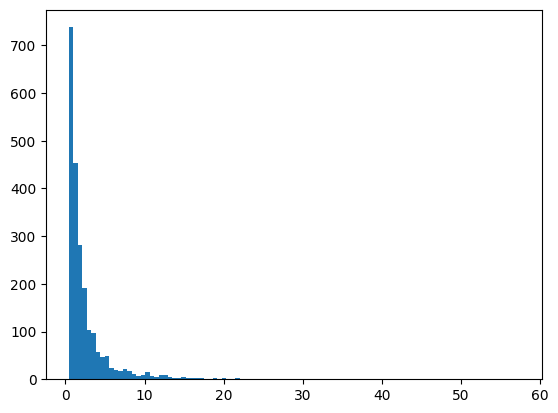

In [9]:
good_sections = get_valid_sections(is_clipping.numpy(), join_close=100)
lens = [(x[1] - x[0]) / 250.0 for x in good_sections]
plt.hist(lens, bins=100)
None

In [10]:
for x in tqdm(range(int(is_clipping.shape[0] * 0.9))):
    if not is_clipping[x:x + 250 * 70].any():
        print(x)

100%|██████████| 1371830/1371830 [00:49<00:00, 27698.78it/s]


# lets build the whole pipeline

In [11]:
data_dir = '/home/ubuntu/small_data/small_data'
all_files = [x for x in os.listdir(data_dir) if '.h5' in x]

In [12]:
all_files[0][:-3]

'link-d7b59ebb-0ebd-44c3-a1ec-c5824b3d563d--654fc03e-d3ae-43e2-8abe-2ab33497f474_1704297062314_session_eeg'

In [48]:
new_path = '/home/ubuntu/small_data/good_chunks/'


for h5_fn in tqdm(all_files[:20]):
    data, _, _ = load_recording(data_dir + '/' + h5_fn)
    filtered = band_pass(torch.tensor(data, device='cuda'), 1, 40).cpu()
    clipped = torch.clip(filtered, -1.95e-4, 1.95e-4)
    is_clipping = torch.any(torch.abs(clipped) == 1.95e-4, axis=0)
    good_sections = get_valid_sections(is_clipping.numpy(), join_close=250, min_length=250 * 60 * 2 + 250 * 8)
    for start, end in good_sections:
        new_fn = new_path + h5_fn[:-3] + f'_sec_{start}_{end}.pt'
        good = filtered[:, start + 250 * 4 : end - 250 * 4]
        good = good - good.mean(axis=1, keepdim=True)
        good = good / good.std()
        torch.save(good, new_fn)

100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


In [30]:
# plot_first_n(res[6][0, :], n=None)
res[6]

IndexError: list index out of range

In [36]:
t = torch.load('/home/ubuntu/small_data/good_chunks/link-0e4e19e4-0c5c-49d9-bfd3-ffc21ecfb67c--14052322-6236-4188-92af-65ca8e2d7094_1703751697544_session_eeg_sec_758027_813049.pt')

t.mean(axis=1)

tensor([-1.4256e-08, -7.7149e-08, -7.1575e-09, -1.0049e-08])

(array([2.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 2.000e+00,
        6.000e+00, 6.000e+00, 5.000e+00, 1.000e+01, 1.100e+01, 1.100e+01,
        2.700e+01, 3.100e+01, 5.800e+01, 7.500e+01, 1.300e+02, 1.760e+02,
        2.500e+02, 3.650e+02, 5.780e+02, 8.040e+02, 1.172e+03, 1.410e+03,
        1.712e+03, 1.797e+03, 2.058e+03, 2.076e+03, 2.205e+03, 2.158e+03,
        2.091e+03, 2.073e+03, 2.005e+03, 1.878e+03, 1.901e+03, 1.899e+03,
        1.849e+03, 2.069e+03, 2.004e+03, 2.180e+03, 2.180e+03, 2.215e+03,
        2.205e+03, 2.159e+03, 1.872e+03, 1.792e+03, 1.471e+03, 1.173e+03,
        8.970e+02, 6.510e+02, 4.330e+02, 2.830e+02, 1.990e+02, 1.050e+02,
        7.300e+01, 4.300e+01, 3.100e+01, 3.400e+01, 1.800e+01, 9.000e+00,
        5.000e+00, 6.000e+00, 5.000e+0

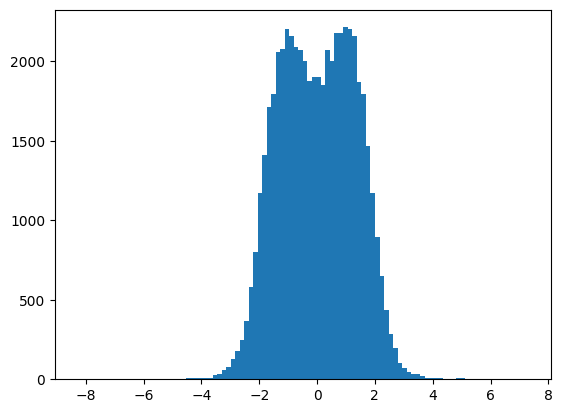

In [47]:
plt.hist(t[0, :] / t.std(), bins=100)
# plot_spec(t[0, :] / t.std())

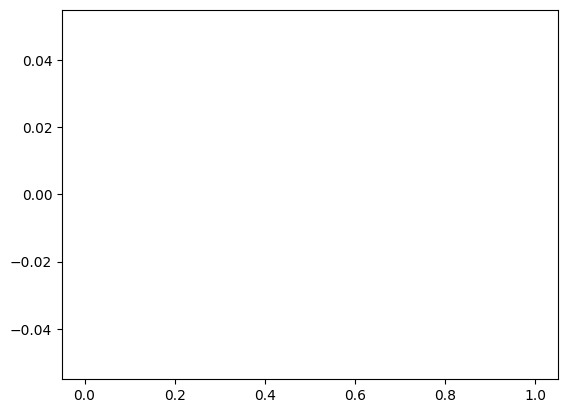

In [14]:
fns = [new_path + '/' + x for x in os.listdir(new_path)]
lens = [torch.load(el).shape[1] / 250 for el in fns]
plt.hist(lens, bins=100)
None

In [15]:
plt.hist(torch.cat([torch.load(el) for el in fns], axis=1).flatten())

RuntimeError: torch.cat(): expected a non-empty list of Tensors

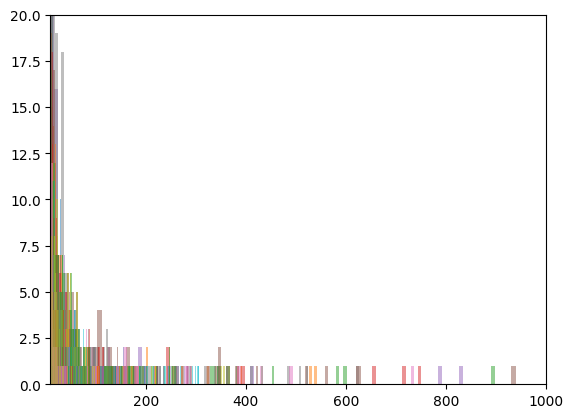

In [ ]:
for x in many_lens:
    plt.hist(x, bins=100, alpha=0.5)
ax = plt.gca().set_ylim([0, 20])
ax = plt.gca().set_xlim([10, 1000])

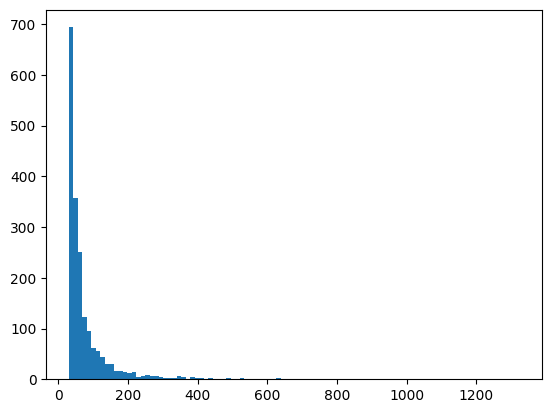

In [ ]:
t = []
[t.extend(x) for x in many_lens]
t = np.array(t)
plt.hist(t[t > 30], bins=100)
None